<a href="https://colab.research.google.com/github/KhushiAgg/Multiagentbot/blob/main/kmultiagentbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libraries

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental langchain_postgres langchain-openai

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your ANTHROPIC_API_KEY··········
Please provide your TAVILY_API_KEY··········


# Create different agents

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

tavily_tool = TavilySearchResults(max_results=1)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. Stop execution once the response is generated"""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

@tool
def text_summarizer(
    summary: Annotated[str, "Summary of text."],
):
    """Use this to summarize the text returned by the researcher
    you should print it out with `print(...)`. This is visible to the user."""
    classifier = pipeline("summarization")
    summary = classifier(summary)
    return summary[0]["summary_text"]



In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from transformers import logging
logging.set_verbosity_error()

@tool
def text_translator(
    translate: Annotated[str, "Translate text from English to Portugese."],
):
    """Use this to translate the text. Stop execution once the response is generated
    you should print it out with `print(...)`. This is visible to the user."""
    tokenizer = AutoTokenizer.from_pretrained("unicamp-dl/translation-en-pt-t5")
    model = AutoModelForSeq2SeqLM.from_pretrained("unicamp-dl/translation-en-pt-t5")
    enpt_pipeline = pipeline('text2text-generation', model=model, tokenizer=tokenizer)
    return enpt_pipeline(f"translate English to Portuguese: {translate}")


In [ ]:
from diffusers import DiffusionPipeline
import torch

@tool
def text_to_image(
    prompt: Annotated[str, "Create an image from given prompt."],

):
    """Use this to create an image from given prompt. Stop execution once the response is generated
    you should print it out with `print(...)`. This is visible to the user."""

    pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
    pipe.to("cuda")
    # prompt = "An astronaut riding a green horse"
    images = pipe(prompt=prompt).images[0]


In [ ]:
from sentence_transformers import SentenceTransformer


@tool
def text_similarity(
    query, document: Annotated[str, "Find similarity of query with the document."],

):
    """Use this to find similarity score of query within the document. Stop execution once the response is generated
    you should print it out with `print(...)`. This is visible to the user."""

    # model = SentenceTransformer(
    # "dunzhang/stella_en_400M_v5",
    # trust_remote_code=True,
    # device="cpu",
    # config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False})

    model = SentenceTransformer('thenlper/gte-large')

    query_embeddings = model.encode([query])
    doc_embeddings = model.encode([document])
    # print(query_embeddings.shape, doc_embeddings.shape)

    # similarities = model.similarity(query_embeddings, doc_embeddings)
    similarities = cos_sim(query_embeddings, doc_embeddings)

    return similarities
    # tensor([[0.7214],
    #         [0.3260]])


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
@tool
def text_ner(
    text: Annotated[str, "Find Named Entity Recognition in a text"],

):
    """Use this to find (Named Entity Recognition) NER provided text. Stop execution once the response is generated
    you should print it out with `print(...)`. This is visible to the user."""

    tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
    model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

    nlp = pipeline("ner", model=model, tokenizer=tokenizer)

    ner_results = nlp(text)
    return ner_results


In [ ]:
import transformers
import torch

@tool
def text_generation(
    messages: Annotated[str, "Generate text based on the prompt provided by the user"],

):
    """Use this to generate text based on the prompt provided by the user. Stop execution once the response is generated
    you should print it out with `print(...)`. This is visible to the user."""

    pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto",
    )

    outputs = pipeline(messages, max_new_tokens=128)
    return outputs[0]["generated_text"][-1]



# Connect to DB

In [ ]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
# db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


# Clean SQL queries generated by LLM

In [ ]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

# Create SQL agent

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [ ]:
 from langchain.chains import create_sql_query_chain
 from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
 from operator import itemgetter
 import re
 from langchain_core.output_parsers import StrOutputParser
 from langchain_core.prompts import PromptTemplate
 from langchain_core.runnables import RunnablePassthrough, RunnableLambda

 @tool
 def db_query_tool(
     question: Annotated[str, "Generate sql query and execute query based on the question asked by the user"],
):

    """Tool to Generate and Execute SQL Query to answer User Questions related to DB. Stop execution once the response is generated"""
    # print("INSIDE NL2SQL TOOL")
    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm, db)
    chain = (
        RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
            result=itemgetter("query") | execute_query
        )
    )

    response = chain.invoke({"question": question})
    print(response)
    return response['result']

In [ ]:
#  question = "List all the genres?"
#  result = db_query_tool.invoke({"question": question})
#  print(f"Answer: {result}")

# Create supervisor node

In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command

import json


members = ["researcher", "coder", "text_summarizer", "text_translator", "text_to_image", "text_similarity", "text_ner", "text_generation", "db_query_tool"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. "
    "researcher is responsible for searching the web, coder is responsible for executing python code and do math, "
    "text_summarization is responsible for summarizing text, text_translator is responsible for translating the text from english to portugese,"
    "text_to_image is responsible for creating an image based on prompt, text_similarity is responsible for finding similarity score of query within the document,"
    "text_ner is responsible for performing Named Entity Recognition, text_generation is responsible for generating text given prompt and question"
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "Routing Guidelines:"
    "'supervisor' Agent: For unclear and vague state messages"
    "Respond with 'FINISH' to end the workflow."
    "If you are able to respond with a good answer after the workers response then Respond with 'FINISH' to end the workflow."
    "If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess."
    "Do not repeat yourself"
    "After you are able to discern all the information, call the relevant tool."
    "When the user question and answer match logically then the workflow can be concluded or continued based on the evaluation"
    " If you have a response from a tool that answers the question, generate the final answer"
    "Respond with FINISH if a function is called more than 3 times for the same task"
    "If there is a technical issue respond with FINISH and stop the workflow"
    )


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["researcher", "coder", "text_summarizer","text_translator", "text_to_image", "text_similarity","text_ner", "text_generation","db_query_tool", "FINISH"]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def supervisor_node(state: MessagesState) -> Command[Literal["researcher", "coder", "text_summarizer","text_translator","text_to_image","text_similarity","text_ner", "text_generation", "db_query_tool", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH" or goto == END:
        goto = END

    return Command(goto=goto)

# Build our graph

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. Focus on gathering infomation. Do not perform any other tasks. DO NOT do any math"
    # DO NOT do any math and DO NOT provide summary and DO NOT translate and DO NOT do any research with prompt and DO NOT research when a query and document is given."
)


def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

text_summarizer_agent = create_react_agent(llm, tools=[text_summarizer],
                                           state_modifier="You are a text summarizer. DO NOT do any math and research. Do not summarize if not asked by user" )


def text_summarizer_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = text_summarizer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="text_summarizer")
            ]
        },
        goto="supervisor",
    )


text_translate_agent = create_react_agent(llm, tools=[text_translator],
                                           state_modifier="You are a text translator. Do not translate until and unless asked by user" )


def text_translator_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = text_translate_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="text_translator")
            ]
        },
        goto="supervisor",
    )

text_to_image_agent = create_react_agent(llm, tools=[text_to_image],
                                           state_modifier="You are a text to image creator." )


def text_to_image_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = text_to_image_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="text_to_image")
            ]
        },
        goto="supervisor",
    )


text_similarity_agent = create_react_agent(llm, tools=[text_similarity],
                                           state_modifier="You need to find similarity score of query within the document." )


def text_similarity_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = text_similarity_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="text_similarity")
            ]
        },
        goto="supervisor",
    )

text_ner_agent = create_react_agent(llm, tools=[text_ner],
                                           state_modifier="You need to perform Named Entity recognition when text is provided." )


def text_ner_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = text_ner_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="text_ner")
            ]
        },
        goto="supervisor",
    )


text_generation_agent = create_react_agent(llm, tools=[text_generation],
                                           state_modifier="You need to perform text generation when a prompt and question is provided." )


def text_generation_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = text_generation_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="text_generation")
            ]
        },
        goto="supervisor",
    )

db_query_agent = create_react_agent(llm, tools=[db_query_tool],
                                           state_modifier="You need to execute SQL query and return the db output" )


def db_query_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = db_query_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="db_query_tool")
            ]
        },
        goto="supervisor",
    )




builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("text_summarizer", text_summarizer_node)
builder.add_node("text_translator", text_translator_node)
builder.add_node("text_to_image", text_to_image_node)
builder.add_node("text_similarity", text_similarity_node)
builder.add_node("text_ner", text_ner_node)
builder.add_node("text_generation", text_generation_node)
builder.add_node("db_query_tool", db_query_node)

graph = builder.compile()

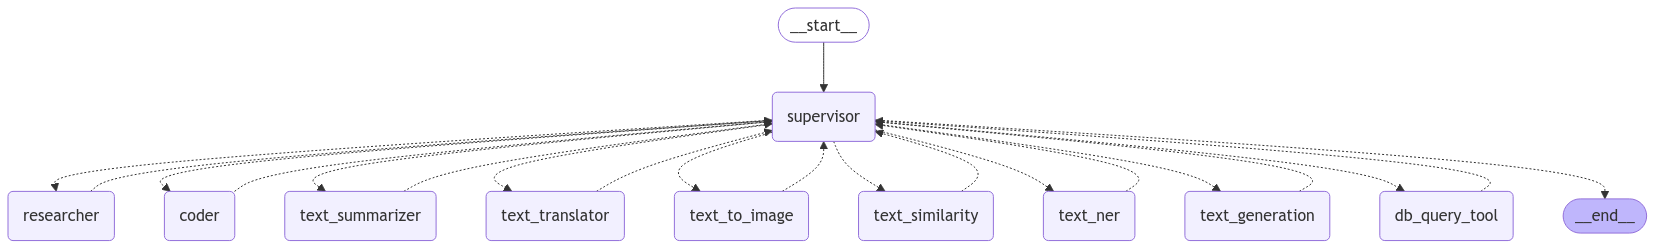

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke multiagent bot with user queries

In [ ]:
for s in graph.stream(
    {"messages": [("user", """Give list of 10 Genres from DB""")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('db_query_tool:798d7d6d-613a-4d9d-e44a-5aeac3b8f9e3',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you get the list of 10 genres from the database using the db_query_tool.", 'type': 'text'}, {'id': 'toolu_013C27ZA5a6TeDGpRXUL9eJy', 'input': {'question': 'Select DISTINCT genre from genres LIMIT 10;'}, 'name': 'db_query_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01AYbk4TwQihKp9jEStyWPxy', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 433, 'output_tokens': 88}}, id='run-a68c1f20-9254-4f82-b436-d3d9206e9554-0', tool_calls=[{'name': 'db_query_tool', 'args': {'question': 'Select DISTINCT genre from genres LIMIT 10;'}, 'id': 'toolu_013C27ZA5a6TeDGpRXUL9eJy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 433, 'output_tokens': 88, 'total_tokens': 521, 'input_token_

In [ ]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [ ]:
import uuid
thread_id = str(uuid.uuid4())
print(thread_id)

config = {
    "configurable": {
        "thread_id": thread_id,
    },
    "recursion_limit": 10
}

_printed = set()
question = """What all tables are there in DB?"""
events = graph.stream(
    {"messages": ('user', question)}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

fd257d5a-df98-498d-a7f7-5a2bf4d5a0e9
================================ Human Message =================================

What all tables are there in DB?
{'question': 'Show all tables in the database', 'query': 'SELECT "name" \nFROM "sqlite_master" \nWHERE "type" = \'table\' AND "name" NOT LIKE \'sqlite_%\';', 'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]"}
================================ Human Message =================================
Name: db_query_tool

Based on the query results, here are all the tables present in the database:

1. Album
2. Artist
3. Customer
4. Employee
5. Genre
6. Invoice
7. InvoiceLine
8. MediaType
9. Playlist
10. PlaylistTrack
11. Track

This appears to be a music store database with tables managing various aspects like music tracks, albums, artists, sales (invoices), customers, and employees.


In [ ]:
for s in graph.stream(
    {"messages": [("user", """Perform text generation given the prompt and question; prompt =
        You are a pirate chatbot who always responds in pirate speak! question = How to say hello in chinese?""")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('text_generation:607b58b5-2cc6-1b0f-a8e7-0ae12746cfe5',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you generate a pirate-themed response about saying hello in Chinese using the text_generation function.", 'type': 'text'}, {'id': 'toolu_01ARLRwikD5tHDqfLk3iEv1c', 'input': {'messages': 'Arr matey! Ye be askin\' how to say hello in the mysterious tongue of the Chinese seas? Well, shiver me timbers, in Mandarin Chinese ye say "Nǐ hǎo" (你好)! It be pronounced like "nee how", ye scurvy dog! \n\nThem Chinese folk be mighty polite with their greetin\'s, and this here phrase be used all across the Seven Seas of the Middle Kingdom! Ye can also just say "hǎo" if yer feelin\' casual, but "Nǐ hǎo" be the proper way to greet yer fellow sailors and landlubbers alike!\n\nArr, now ye can spread some Chinese cheer on yer next plunderin\' voyage! Just remember to say it with a hearty pirate smile, ye barnacle-covered buccaneer! 🏴\u200d☠️'}, 'name': '

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

(('text_generation:607b58b5-2cc6-1b0f-a8e7-0ae12746cfe5',), {'tools': {'messages': [ToolMessage(content='Error: ValueError(\'Could not load model microsoft/phi-4 with any of the following classes: (<class \\\'transformers.models.auto.modeling_auto.AutoModelForCausalLM\\\'>, <class \\\'transformers.models.auto.modeling_tf_auto.TFAutoModelForCausalLM\\\'>, <class \\\'transformers.models.phi3.modeling_phi3.Phi3ForCausalLM\\\'>). See the original errors:\\n\\nwhile loading with AutoModelForCausalLM, an error is thrown:\\nTraceback (most recent call last):\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py", line 289, in infer_framework_load_model\\n    model = model_class.from_pretrained(model, **kwargs)\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py", line 564, in from_pretrained\\n    return model_class.from_pretrained(\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 4342, in

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

(('text_generation:607b58b5-2cc6-1b0f-a8e7-0ae12746cfe5',), {'tools': {'messages': [ToolMessage(content='Error: ValueError(\'Could not load model microsoft/phi-4 with any of the following classes: (<class \\\'transformers.models.auto.modeling_auto.AutoModelForCausalLM\\\'>, <class \\\'transformers.models.auto.modeling_tf_auto.TFAutoModelForCausalLM\\\'>, <class \\\'transformers.models.phi3.modeling_phi3.Phi3ForCausalLM\\\'>). See the original errors:\\n\\nwhile loading with AutoModelForCausalLM, an error is thrown:\\nTraceback (most recent call last):\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py", line 289, in infer_framework_load_model\\n    model = model_class.from_pretrained(model, **kwargs)\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py", line 564, in from_pretrained\\n    return model_class.from_pretrained(\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 4342, in

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

(('text_generation:607b58b5-2cc6-1b0f-a8e7-0ae12746cfe5',), {'tools': {'messages': [ToolMessage(content='Error: ValueError(\'Could not load model microsoft/phi-4 with any of the following classes: (<class \\\'transformers.models.auto.modeling_auto.AutoModelForCausalLM\\\'>, <class \\\'transformers.models.auto.modeling_tf_auto.TFAutoModelForCausalLM\\\'>, <class \\\'transformers.models.phi3.modeling_phi3.Phi3ForCausalLM\\\'>). See the original errors:\\n\\nwhile loading with AutoModelForCausalLM, an error is thrown:\\nTraceback (most recent call last):\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py", line 289, in infer_framework_load_model\\n    model = model_class.from_pretrained(model, **kwargs)\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py", line 564, in from_pretrained\\n    return model_class.from_pretrained(\\n  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 4342, in

In [ ]:
for s in graph.stream(
    {"messages": [("user", """Find Named Entity recognition given text- text = "My name is Wolfgang and I live in Berlin" """)]}, subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('text_ner:a7fac42f-6818-9f4b-4299-c3f0614ede58',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you find Named Entity Recognition (NER) for the given text using the text_ner function.", 'type': 'text'}, {'id': 'toolu_01WgUxC8g5wjGkjxskVmpSEx', 'input': {'text': 'My name is Wolfgang and I live in Berlin'}, 'name': 'text_ner', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UTRzE96RcUuqYqmKwyfbia', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 448, 'output_tokens': 87}}, id='run-96e49b98-9687-4c63-aa87-635d4d39dd3a-0', tool_calls=[{'name': 'text_ner', 'args': {'text': 'My name is Wolfgang and I live in Berlin'}, 'id': 'toolu_01WgUxC8g5wjGkjxskVmpSEx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 448, 'output_tokens': 87, 'total_tokens': 535, 'input_token_details': {'ca

KeyboardInterrupt: 

In [ ]:
for s in graph.stream(
    {"messages": [("user", """Find similarity score of the given query within the document- query: Is she happy?,
    document: That is a very happy person""")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('text_similarity:1187ff4c-7a50-b6e0-af75-32d4574bc9ed',), {'agent': {'messages': [AIMessage(content=[{'text': 'I\'ll help you find the similarity score between the query "Is she happy?" and the document "That is a very happy person" using the text_similarity function.', 'type': 'text'}, {'id': 'toolu_01RUhxe7UayLd48MdANGo3Sk', 'input': {'query': 'Is she happy?', 'document': 'That is a very happy person'}, 'name': 'text_similarity', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01JmpAFHrT8hgmyKv2sNBPov', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 459, 'output_tokens': 113}}, id='run-93cec766-e6f8-464d-b01c-ce7f1791e212-0', tool_calls=[{'name': 'text_similarity', 'args': {'query': 'Is she happy?', 'document': 'That is a very happy person'}, 'id': 'toolu_01RUhxe7UayLd48MdANGo3Sk', 'type': 'tool

In [ ]:
for s in graph.stream(
    {"messages": [("user", """Text to Image: Given Prompt: You are Sundar Pichai teaching kids.""")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


(('text_summarizer:0d477722-2db5-18fa-3706-7dc44fc48400',), {'agent': {'messages': [AIMessage(content=[{'text': 'Let me help summarize how to describe a text prompt for an image of Sundar Pichai teaching kids.', 'type': 'text'}, {'id': 'toolu_019C5Pu2QQUVQegKQzDTdLUs', 'input': {'summary': 'The image prompt describes a scene where Sundar Pichai, the CEO of Google/Alphabet, is in a teaching role with children. This would likely depict:\n\n1. Sundar Pichai in his characteristic business casual attire\n2. A classroom or educational setting\n3. Children seated or gathered around him\n4. An interactive teaching moment\n5. Possibly technology-related educational content given his background\n6. A warm, engaging expression as he explains concepts to kids\n\nThe scene suggests a professional yet approachable atmosphere where a tech industry leader is sharing knowledge with young learners.'}, 'name': 'text_summarizer', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu
Your max_length is set to 142, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


(('text_summarizer:0d477722-2db5-18fa-3706-7dc44fc48400',), {'tools': {'messages': [ToolMessage(content=' The image prompt describes a scene where Sundar Pichai, the CEO of Google/Alphabet, is in a teaching role with children . The scene suggests a professional yet approachable atmosphere where a tech industry leader is sharing knowledge with young learners . This would likely depict: The CEO in his characteristic business casual attire, a classroom or educational setting, children seated or gathered around him .', name='text_summarizer', id='ec9a75d1-f7b9-4ba2-be8b-57d0e349256b', tool_call_id='toolu_019C5Pu2QQUVQegKQzDTdLUs')]}})
----
(('text_summarizer:0d477722-2db5-18fa-3706-7dc44fc48400',), {'agent': {'messages': [AIMessage(content=[], additional_kwargs={}, response_metadata={'id': 'msg_018PLHrAu4979aDWGDtX5wSh', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_t

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

(('text_to_image:d8ddc893-a1ca-a437-088b-5687668b4965',), {'tools': {'messages': [ToolMessage(content="Error: RuntimeError('Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx')\n Please fix your mistakes.", name='text_to_image', id='b516a8d9-f7bf-4f59-99a3-c4aa9165fb15', tool_call_id='toolu_01WGg273t7ZZT5CTydH7rMJ6', status='error')]}})
----
(('text_to_image:d8ddc893-a1ca-a437-088b-5687668b4965',), {'agent': {'messages': [AIMessage(content="I apologize for the technical error in generating the image. It seems there's an issue with the system's GPU configuration. However, I've provided an appropriate prompt that would create an image showing:\n- Sundar Pichai in a teaching pose\n- A classroom setting with kids\n- An educational atmosphere\n- Pichai explaining something with a friendly demeanor\n- Students engaged in learning\n\nWould you like to try generating the image again, or would you

In [ ]:
for s in graph.stream(
    {"messages": [("user", """Translate from English to Portugese: My name is Bot""")]}, subgraphs=True
):
    print(s)
    # json_s = json.dumps(s, indent=4)
    # print(json_s)
    print("----")

((), {'supervisor': None})
----
(('text_translator:70458a47-92de-59ce-7789-ad992b9a4e49',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you translate that sentence from English to Portuguese using the text_translator function.", 'type': 'text'}, {'id': 'toolu_01TimjydfZtWDBJgAAPfSbqf', 'input': {'translate': 'My name is Bot'}, 'name': 'text_translator', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_011CxWpnDHAmknHj1h3Tegwn', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 437, 'output_tokens': 75}}, id='run-70919007-e800-4cb8-a1e2-5b8105522b49-0', tool_calls=[{'name': 'text_translator', 'args': {'translate': 'My name is Bot'}, 'id': 'toolu_01TimjydfZtWDBJgAAPfSbqf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 437, 'output_tokens': 75, 'total_tokens': 512, 'input_token_details': {'cache_read': 0, 'cac

In [ ]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    # print(s["messages"][-1].pretty_print())
    print("----")

((), {'supervisor': None})
----


(('coder:4c5552d1-d62c-ff30-f18e-246549904e13',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you calculate the square root of 42 using Python.", 'type': 'text'}, {'id': 'toolu_013zkjJk2F1fhynBvEa8dur7', 'input': {'code': 'import math\nprint(math.sqrt(42))'}, 'name': 'python_repl_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_016jUJrdxxjycpBRsL4EdR2b', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 435, 'output_tokens': 82}}, id='run-2eb83bae-a0d0-4d2a-83f9-02b98ccc84bd-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'toolu_013zkjJk2F1fhynBvEa8dur7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 435, 'output_tokens': 82, 'total_tokens': 517, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}})
----
(('coder:4c5552d1-d62c-ff

In [ ]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:d0e93a5e-6d39-5d87-0721-dc4a3d4acfd8',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help gather information about the GDP of New York and California. However, as instructed, I won't perform any mathematical calculations.\n\nLet me search for the most recent GDP data for both states.", 'type': 'text'}, {'id': 'toolu_01HCJaaua764zZWWtKQKduVc', 'input': {'query': 'latest GDP New York state 2023 2024'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RaTSL93M25GdyAA9ybCtGE', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 455, 'output_tokens': 111}}, id='run-bc57efc7-616c-401e-9a3f-0771381528b3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP New York state 2023 2024'}, 'id': 'toolu_01HCJaaua764zZWWtK

In [ ]:
import uuid
thread_id = str(uuid.uuid4())
print(thread_id)

config = {
    "configurable": {
        "thread_id": thread_id,
    },
    "recursion_limit": 20
}

_printed = set()
question = "Give full form HTTP"
# question = "What are the unique values of protocols dimension from procedures table?"
events = graph.stream(
    {"messages": ('user', question)}, config, stream_mode="values"
)
for event in events:
    # print(event)
    _print_event(event, _printed)

bd5ce55f-a658-4808-989c-dbad484372ed
================================ Human Message =================================

Give full form HTTP


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 